In [1]:
!pip install emoji

In [2]:
!pip install wordcloud

In [3]:
import os
import re
import nltk
import json
import string
import emoji
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

In [4]:
base_path = os.getcwd() 

In [5]:
train_path = os.path.join(base_path, 'data\\train.tsv')
test_path = os.path.join(base_path, 'data\\test.tsv')
dev_path = os.path.join(base_path, 'data\\dev.tsv')
emotions_path = os.path.join(base_path, 'data\\emotions.txt')
ekman_mapping_path = os.path.join(base_path, 'data\\ekman_mapping.json')

In [6]:
train_df = pd.read_csv(train_path, sep='\t', header=None, names=['text', 'emotion_id', 'id'])
test_df = pd.read_csv(test_path, sep='\t', names=['text', 'emotion_id', 'id'])
dev_df = pd.read_csv(dev_path, sep='\t', names=['text', 'emotion_id', 'id'])

with open(emotions_path, 'r') as f:
    emotions = [line.strip() for line in f]

with open(ekman_mapping_path) as file:
    ekman_mapping = json.load(file)

In [7]:
print(emotions)

['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']


In [8]:
print(ekman_mapping)

{'anger': ['anger', 'annoyance', 'disapproval'], 'disgust': ['disgust'], 'fear': ['fear', 'nervousness'], 'joy': ['joy', 'amusement', 'approval', 'excitement', 'gratitude', 'love', 'optimism', 'relief', 'pride', 'admiration', 'desire', 'caring'], 'sadness': ['sadness', 'disappointment', 'embarrassment', 'grief', 'remorse'], 'surprise': ['surprise', 'realization', 'confusion', 'curiosity']}


In [9]:
train_df.head()

,text,emotion_id,id
0,My favourite food is anything I didn't have to...,27,eebbqej
1,"Now if he does off himself, everyone will thin...",27,ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj
3,To make her feel threatened,14,ed7ypvh
4,Dirty Southern Wankers,3,ed0bdzj


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43410 entries, 0 to 43409
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        43410 non-null  object
 1   emotion_id  43410 non-null  object
 2   id          43410 non-null  object
dtypes: object(3)
memory usage: 1017.6+ KB


In [11]:
train_df['emotion_list'] = train_df['emotion_id'].apply(lambda x: x.split(','))
train_df['no_emotions'] = train_df['emotion_list'].apply(lambda x: len(x))

test_df['emotion_list'] = test_df['emotion_id'].apply(lambda x: x.split(','))
test_df['no_emotions'] = test_df['emotion_list'].apply(lambda x: len(x))

dev_df['emotion_list'] = dev_df['emotion_id'].apply(lambda x: x.split(','))
dev_df['no_emotions'] = dev_df['emotion_list'].apply(lambda x: len(x))

In [12]:
def id_to_emotion(id_list):
    arr = []
    for i in id_list:
        arr.append(emotions[int(i)])
    return arr

train_df['emotions'] = train_df['emotion_list'].apply(id_to_emotion)
test_df['emotions'] = test_df['emotion_list'].apply(id_to_emotion)
dev_df['emotions'] = dev_df['emotion_list'].apply(id_to_emotion)

In [13]:
train_df.head()

,text,emotion_id,id,emotion_list,no_emotions,emotions
0,My favourite food is anything I didn't have to...,27,eebbqej,[27],1,[neutral]
1,"Now if he does off himself, everyone will thin...",27,ed00q6i,[27],1,[neutral]
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj,[2],1,[anger]
3,To make her feel threatened,14,ed7ypvh,[14],1,[fear]
4,Dirty Southern Wankers,3,ed0bdzj,[3],1,[annoyance]


In [14]:
def plot_emotion_distribution(df, column_name, plot_title):
    """
    Plot the distribution of emotions from a specified column in a DataFrame.
    
    Args:
        df (pd.DataFrame): The input DataFrame.
        column_name (str): The name of the column containing emotions (list or single value).
    
    Returns:
        None: Displays the plot.
    """
    # Flatten the emotions
    flattened_emotions = [emotion for sublist in df[column_name] for emotion in (sublist if isinstance(sublist, list) else [sublist])]
    
    # Count each emotion
    emotion_counts = Counter(flattened_emotions)
    
    # Convert counts to a DataFrame for visualization
    emotion_counts_df = pd.DataFrame(emotion_counts.items(), columns=['Emotion', 'Count'])
    
    # Plot the distribution of emotions
    plt.figure(figsize=(10, 6))
    emotion_counts_df.sort_values('Count', ascending=False).set_index('Emotion').plot(kind='bar', legend=None)
    plt.title(plot_title)
    plt.xlabel("Emotion")
    plt.ylabel("Frequency")
    plt.xticks(rotation=90)
    plt.show()

<Figure size 1000x600 with 0 Axes>

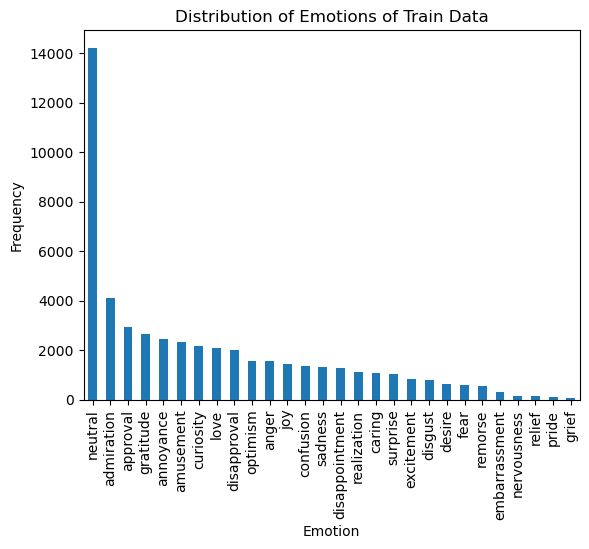

In [15]:
plot_emotion_distribution(train_df, 'emotions', 'Distribution of Emotions of Train Data')

<Figure size 1000x600 with 0 Axes>

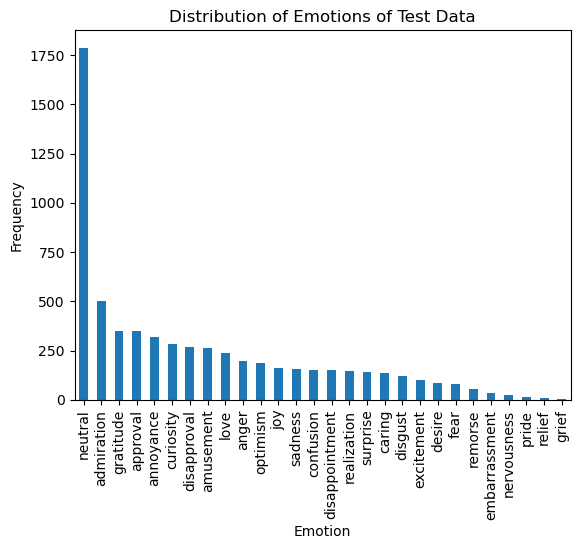

In [16]:
plot_emotion_distribution(test_df, 'emotions', 'Distribution of Emotions of Test Data')

<Figure size 1000x600 with 0 Axes>

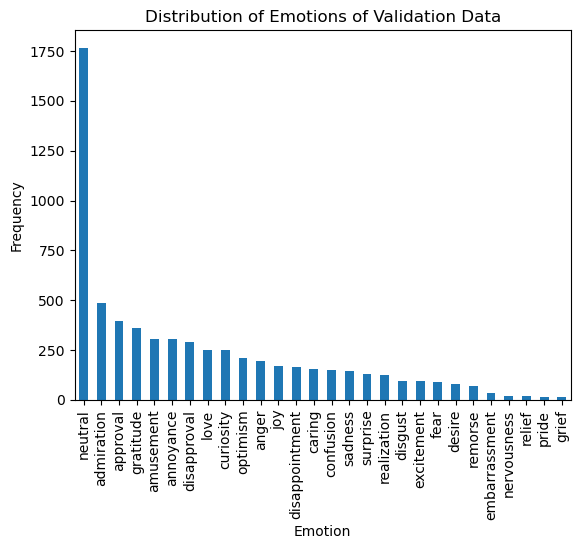

In [17]:
plot_emotion_distribution(dev_df, 'emotions', 'Distribution of Emotions of Validation Data')

In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43410 entries, 0 to 43409
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          43410 non-null  object
 1   emotion_id    43410 non-null  object
 2   id            43410 non-null  object
 3   emotion_list  43410 non-null  object
 4   no_emotions   43410 non-null  int64 
 5   emotions      43410 non-null  object
dtypes: int64(1), object(5)
memory usage: 2.0+ MB


### Data Preprocessing

In [19]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [20]:
def remove_emojis(text):
    """
    Remove emojis from the text using the emoji library.
    """
    return emoji.replace_emoji(text, replace="")  # Replace emojis with an empty string

def lemmatization(text):
    text = text.split()
    text = [lemmatizer.lemmatize(word) for word in text]
    return " ".join(text)

def remove_stop_words(text):
    text = [word for word in str(text).split() if word not in stop_words]
    return " ".join(text)

def Removing_numbers(text):
    text = ''.join([char for char in text if not char.isdigit()])
    return text

def lower_case(text):
    text = text.split()
    text = [word.lower() for word in text]
    return " ".join(text)

def Removing_punctuations(text):
    # Remove punctuations
    punctuation_pattern = re.escape(r"""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~""")
    text = re.sub(rf"[{punctuation_pattern}]", ' ', text)  # Use raw f-string for clarity
    text = text.replace('؛', "")
    
    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text)  # Raw string to handle whitespace correctly
    return text.strip()

def Removing_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_small_sentences(df):
    for i in range(len(df)):
        if len(df.text.iloc[i].split()) < 3:
            df.text.iloc[i] = np.nan

def normalize_text(df):
    df['text'] = df['text'].apply(lower_case)
    df['text'] = df['text'].apply(remove_stop_words)
    df['text'] = df['text'].apply(Removing_numbers)
    df['text'] = df['text'].apply(Removing_punctuations)
    df['text'] = df['text'].apply(Removing_urls)
    df['text'] = df['text'].apply(remove_emojis)  # New step to remove emojis
    df['text'] = df['text'].apply(lemmatization)
    return df

def normalized_sentence(sentence):
    sentence = lower_case(sentence)
    sentence = remove_stop_words(sentence)
    sentence = Removing_numbers(sentence)
    sentence = Removing_punctuations(sentence)
    sentence = Removing_urls(sentence)
    sentence = remove_emojis(sentence)  # New step to remove emojis
    sentence = lemmatization(sentence)
    return sentence


In [21]:
train_df = normalize_text(train_df)
test_df = normalize_text(test_df)
dev_df = normalize_text(dev_df)

In [22]:
# Drop rows where 'text' column has NaN values
train_df.dropna(subset=['text'], inplace=True)
test_df.dropna(subset=['text'], inplace=True)
dev_df.dropna(subset=['text'], inplace=True)

In [23]:
# Reset the index for clean DataFrames
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
dev_df.reset_index(drop=True, inplace=True)

In [24]:
def expand_emotion_dataset(df):
    """
    Expands a dataset where each row may contain multiple emotions into one row per emotion.
    
    Parameters:
        df (pd.DataFrame): Original dataset with columns 'text', 'emotion_id', 'id', 
                           'emotion_list', 'no_emotions', 'emotions'.
    
    Returns:
        pd.DataFrame: Expanded dataset with one row per emotion.
    """
    expanded_data = []
    for _, row in df.iterrows():
        for emotion_id, emotion in zip(row['emotion_list'], row['emotions']):
            expanded_data.append({
                "text": row['text'],
                "emotions": emotion
            })
    return pd.DataFrame(expanded_data)

In [25]:
expended_train_df = expand_emotion_dataset(train_df)
expended_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51103 entries, 0 to 51102
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      51103 non-null  object
 1   emotions  51103 non-null  object
dtypes: object(2)
memory usage: 798.6+ KB


In [26]:
expended_test_df = expand_emotion_dataset(test_df)
expended_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6329 entries, 0 to 6328
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      6329 non-null   object
 1   emotions  6329 non-null   object
dtypes: object(2)
memory usage: 99.0+ KB


In [27]:
expended_dev_df = expand_emotion_dataset(dev_df)
expended_dev_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6380 entries, 0 to 6379
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      6380 non-null   object
 1   emotions  6380 non-null   object
dtypes: object(2)
memory usage: 99.8+ KB


In [28]:
expended_train_df.head()

,text,emotions
0,favourite food anything cook myself,neutral
1,himself everyone think he laugh screwing peopl...,neutral
2,fuck bayless isoing,anger
3,make feel threatened,fear
4,dirty southern wanker,annoyance


In [29]:
print('Train Emotion Count: ' + str(expended_train_df['emotions'].value_counts()))
print('Test Emotion Count: ' + str(expended_test_df['emotions'].value_counts()))
print('Dev Emotion Count: ' + str(expended_dev_df['emotions'].value_counts()))

Train Emotion Count: emotions
neutral           14219
admiration         4130
approval           2939
gratitude          2662
annoyance          2470
amusement          2328
curiosity          2191
love               2086
disapproval        2022
optimism           1581
anger              1567
joy                1452
confusion          1368
sadness            1326
disappointment     1269
realization        1110
caring             1087
surprise           1060
excitement          853
disgust             793
desire              641
fear                596
remorse             545
embarrassment       303
nervousness         164
relief              153
pride               111
grief                77
Name: count, dtype: int64
Test Emotion Count: emotions
neutral           1787
admiration         504
gratitude          352
approval           351
annoyance          320
curiosity          284
disapproval        267
amusement          264
love               238
anger              198
optimism     

In [30]:
# Define emotions to remove
emotions_to_remove = ['neutral', 'admiration', 'approval', 'gratitude','amusement']

# Remove specified emotions from Train, Test, and Dev datasets
expended_train_df = expended_train_df[~expended_train_df['emotions'].isin(emotions_to_remove)]
expended_test_df = expended_test_df[~expended_test_df['emotions'].isin(emotions_to_remove)]
expended_dev_df = expended_dev_df[~expended_dev_df['emotions'].isin(emotions_to_remove)]

In [31]:
emotion_mapping = {
    "anger": ["anger", "annoyance", "disapproval"],
    "disgust": ["disgust"],
    "fear": ["fear", "nervousness"],
    "joy": ["joy", "amusement", "excitement", "love", "optimism", "relief", "pride", "desire", "caring"],
    "sadness": ["sadness", "disappointment", "embarrassment", "grief", "remorse"],
    "surprise": ["surprise", "realization", "confusion", "curiosity"]
}

In [32]:
# Function to group and summarize emotion counts by category
def summarize_emotion_categories(expanded_df, emotion_mapping):
    """
    Summarizes emotion counts by broader categories defined in emotion_mapping.
    
    Parameters:
        expanded_df (pd.DataFrame): DataFrame with an 'emotions' column (list or string of emotions).
        emotion_mapping (dict): Dictionary mapping categories to a list of emotions.
    
    Returns:
        pd.Series: Counts of each broader category.
    """
    # Create reverse mapping for emotions to categories
    emotion_to_category = {emotion: category for category, emotions in emotion_mapping.items() for emotion in emotions}
    
    # Flatten 'emotions' column and map to categories
    expanded_df["category"] = expanded_df["emotions"].apply(lambda x: emotion_to_category[x[0]] if isinstance(x, list) else emotion_to_category[x])
    
    # Summarize counts by category
    return expanded_df["category"].value_counts()

# Apply the function to Train, Test, and Dev datasets
train_summary = summarize_emotion_categories(expended_train_df, emotion_mapping)
test_summary = summarize_emotion_categories(expended_test_df, emotion_mapping)  # Replace with expended_test_df
dev_summary = summarize_emotion_categories(expended_dev_df, emotion_mapping)  # Replace with expended_dev_df

# Print summaries
print('Train Emotion Count: ' + str(train_summary))
print('Test Emotion Count: ' + str(test_summary))
print('Dev Emotion Count: ' + str(dev_summary))

Train Emotion Count: category
joy         7964
anger       6059
surprise    5729
sadness     3520
disgust      793
fear         760
Name: count, dtype: int64
Test Emotion Count: category
joy         933
anger       785
surprise    723
sadness     406
disgust     123
fear        101
Name: count, dtype: int64
Dev Emotion Count: category
joy         992
anger       790
surprise    656
sadness     422
fear        111
disgust      97
Name: count, dtype: int64


In [33]:
# Removing the 'emotions' column, removing duplicate rows, and renaming 'category' to 'sentiment'
def clean_emotion_data(df):
    """
    Cleans the emotion data by:
    1. Removing the 'emotions' column.
    2. Removing duplicate rows with the same 'text' and 'category'.
    3. Renaming 'category' to 'sentiment'.

    Parameters:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: Cleaned DataFrame.
    """
    # Drop the 'emotions' column
    df = df.drop(columns=['emotions'])
    
    # Remove duplicate rows based on 'text' and 'category'
    df = df.drop_duplicates(subset=['text', 'category'])
    
    # Rename 'category' to 'sentiment'
    df = df.rename(columns={'category': 'sentiment'})
    
    return df

In [34]:
preprocessed_train_df = clean_emotion_data(expended_train_df)
preprocessed_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22831 entries, 2 to 51102
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       22831 non-null  object
 1   sentiment  22831 non-null  object
dtypes: object(2)
memory usage: 535.1+ KB


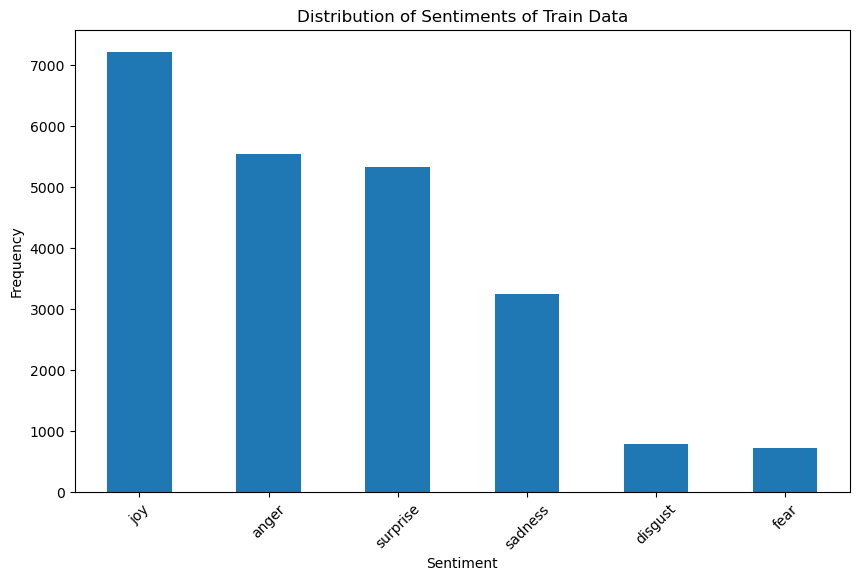

In [35]:
plt.figure(figsize=(10, 6))
preprocessed_train_df['sentiment'].value_counts().plot(kind='bar')
plt.title("Distribution of Sentiments of Train Data")
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

In [36]:
preprocessed_test_df = clean_emotion_data(expended_test_df)
preprocessed_test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2859 entries, 0 to 6321
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       2859 non-null   object
 1   sentiment  2859 non-null   object
dtypes: object(2)
memory usage: 67.0+ KB


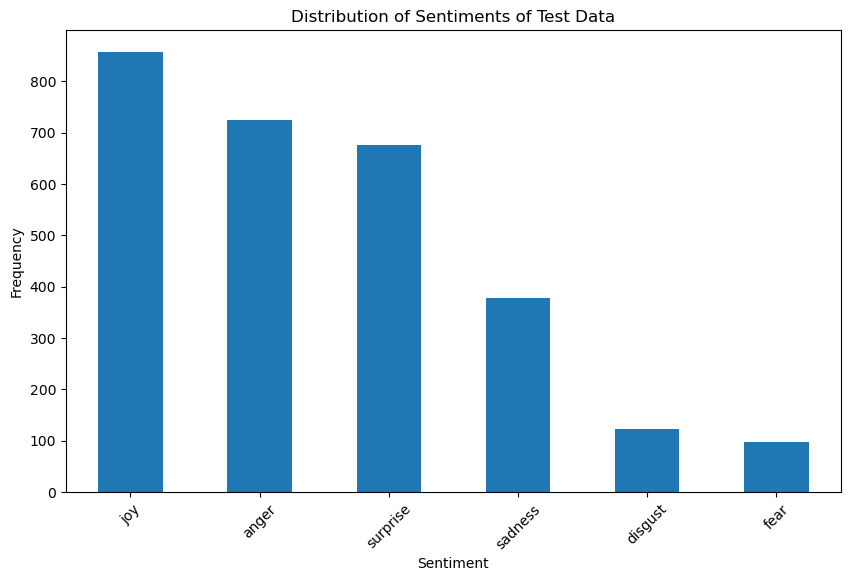

In [37]:
plt.figure(figsize=(10, 6))
preprocessed_test_df['sentiment'].value_counts().plot(kind='bar')
plt.title("Distribution of Sentiments of Test Data")
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

In [38]:
preprocessed_dev_df = clean_emotion_data(expended_dev_df)
preprocessed_dev_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2854 entries, 3 to 6379
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       2854 non-null   object
 1   sentiment  2854 non-null   object
dtypes: object(2)
memory usage: 66.9+ KB


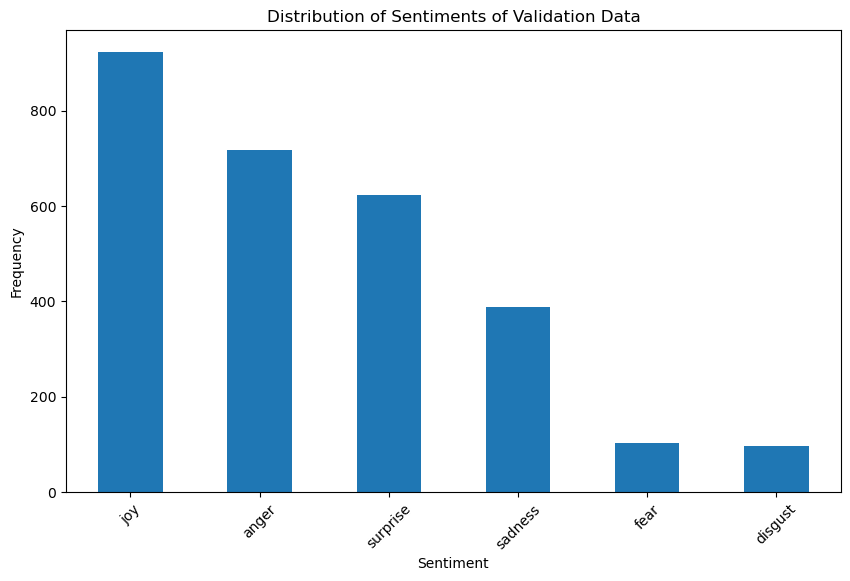

In [39]:
plt.figure(figsize=(10, 6))
preprocessed_dev_df['sentiment'].value_counts().plot(kind='bar')
plt.title("Distribution of Sentiments of Validation Data")
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

In [40]:
preprocessed_train_df.isnull().sum()

text         0
sentiment    0
dtype: int64

In [41]:
preprocessed_test_df.isnull().sum()

text         0
sentiment    0
dtype: int64

In [42]:
preprocessed_dev_df.isnull().sum()

text         0
sentiment    0
dtype: int64

### Export to CSV

In [43]:
preprocessed_train_df.to_csv('preprocessed_train.csv', index=False)
preprocessed_test_df.to_csv('preprocessed_test.csv', index=False)
preprocessed_dev_df.to_csv('preprocessed_val.csv', index=False)